Inside Main function
Twitter Authentication is successfull
cursor :  <tweepy.cursor.ItemIterator object at 0x000002660A48DB40>


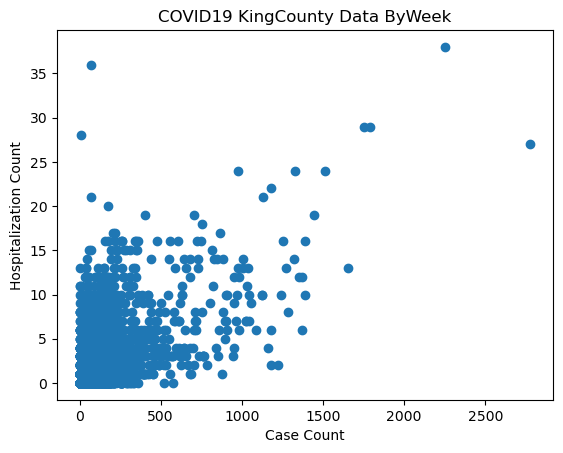

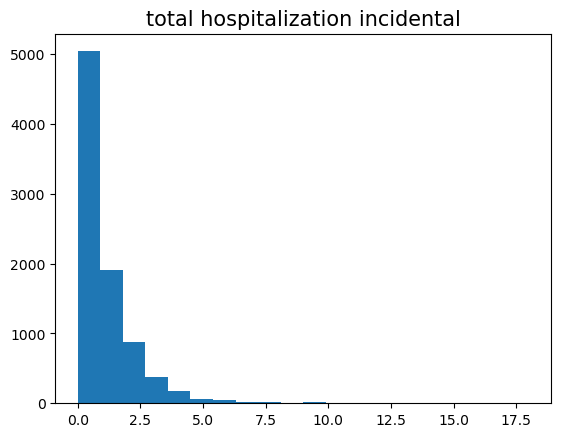

TypeError: 'numpy.ndarray' object is not callable

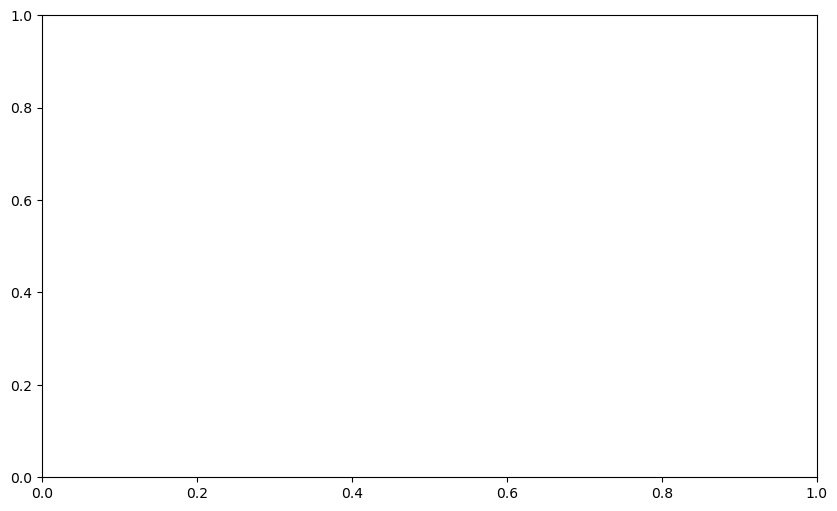

In [41]:
"""
DSC540 Week 9 and 10 assignment Exercise
"""

from __future__ import print_function
from itertools import zip_longest

import csv
import logging
import sys
import numpy as np
import pandas as pd
import random
import thinkplot
import thinkstats2
import datetime
import regression
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
import pandas as pd
import sqlite3
import urllib.request, urllib.parse, urllib.error
import requests
from bs4 import BeautifulSoup
import re
import json
import tweepy
from requests_oauthlib import OAuth1Session
import os
import json
from textblob import TextBlob
%matplotlib inline

 # For activity 10 I have loaded the secret API key (we have to get one from OMDB website and use that, 1000 daily limit) from a JSON file, stored in the same folder into a variable. 
 # I received key from omdbapi which is simple text. It is not JSON file. I copied it to APIKey.json file in same directory.
 # The 'APIkeys.json' file is placed in the working directory and has following keys to access OMDBapi and Twitter api-key,api-secret-key, access-token and access-token-secret

# Connect to the Twitter API and do a simple data pull
# a. If we don’t have a twitter account – create one at twitter.com/signup (you can delete the account after this assignment)
# b. Sign in to apps.twitter.com
# c. Click “Create New App”
# d. Give app a name and description
# e. Agree to the developer agreement – you will want to make sure to indicate this is for a class project, and this step can take several days to get through, so don’t wait until last minute to complete this portion of the assignment
# f. Create an access token
# g. We should receive a consumer key and a token h. Using either the instructions from the book on connecting to an API or for help look here – pull back data searching for “Bellevue University” and “Data Science” (or something else you are interested in)
# Generally any REST API can be consumed using requests library. Twitter also exposes REST API.

with open('APIkeys.json') as f:
        keys = json.load(f)
        omdbapi = keys['OMDBapi']
        api_key = keys['twitter-api-key']
        api_secret_key = keys['twitter-api-secret-key']
        access_token = keys['twitter-access-token']
        access_token_secret = keys['twitter-access-token-secret']

serviceurl = 'http://www.omdbapi.com/?'
apikey = '&apikey='+omdbapi

def ReadData(file_url):
    # For SSL ceritficates verification will specify parameter verify=True
    resp = requests.get(file_url,verify=True)
    return resp

# Following Linux standard, I will return 0 in case of successful request
# And will return any non-zero number in case of failure (in this case non-zero number I chose is 255)
def status_check(r):
    if r.status_code==200:
        print("Success!")
        return 0
    else:
        print("Failed!")
        return 255

def PerformExerciseActivity_9():
    gutenberg_url = 'https://www.gutenberg.org/browse/scores/top'
    # For SSL ceritficates verification will specify parameter verify=True
    # function to read the So Much Data Candy, Seriously (Ng, 2017) data
    resp = ReadData(gutenberg_url)
    status_check(resp)
    
    soup = BeautifulSoup(resp.text)

    # Empty list to hold all the http links in the HTML page
    lst_links=[]

    # Find all the anchor tags  and then link inside it
    for link in soup.find_all('a'):
        #print(link.get('href'))
        lst_links.append(link.get('href'))

    print('lst_links[:50] :', lst_links[:50])

    # the lList shows that there are multiple hyperlinks on page. But actuall hyperlinks for books start only from entry /ebook/1342. All previous links are just for navigation on the site.
    # So lets find the index of /ebook/1342
    index_of_first_book_link = lst_links.index('/ebooks/1342')
    print('index_of_first_book_link :', index_of_first_book_link)

    # As we need list of 100 most popular books will run the loop for 100 records starting from index 33 to 133
    booknum=[]
    for i in range(33,133):
        link=lst_links[i]
        link=link.strip()
        # Regular expression to find the numeric digits in the link (href) string
        n=re.findall('[0-9]+',link)
        if len(n)==1:
            # Append the filenumber casted as integer
            booknum.append(n[0])
    
    print ("\nThe file numbers for the top 100 ebooks on Gutenberg are shown below\n")
    nl = '\n'
    text = f"Winners are:{nl}{nl.join(booknum[:100])}"
    print(text)
    print(f"{ soup.text[:1100] } ")

    # Looking at web page first book in the list appears to be "Alice's Adventures in Wonderland by Lewis Carroll (910)" Using splitlines to extract each book entry from text to a list
    # Temp empty list of Ebook names
    lst_titles_temp=[]
    start_idx=soup.text.splitlines().index("Alice's Adventures in Wonderland by Lewis Carroll (910)")

    # Capturing 100 books entries in a list.
    for i in range(100):
        lst_titles_temp.append(soup.text.splitlines()[start_idx+i])

    # Using regex to filter Titles only stripping (number) part
    lst_titles=[]
    for i in range(100):
        id1,id2=re.match('^[a-zA-Z ]*',lst_titles_temp[i]).span()
        lst_titles.append(lst_titles_temp[i][id1:id2])
    
    for l in lst_titles:
        print(l)

# Function to print json data in formatted form.
def print_json(json_data):
    list_keys=['Title', 'Year', 'Rated', 'Released', 'Runtime', 'Genre', 'Director', 'Writer', 
               'Actors', 'Plot', 'Language', 'Country', 'Awards', 'Ratings', 
               'Metascore', 'imdbRating', 'imdbVotes', 'imdbID','Poster']
    print("-"*50)
    for k in list_keys:
        if k in list(json_data.keys()):
            print(f"{k}: {json_data[k]}")
    print("-"*50)

# Function to ssearch movie from API endpoint
def search_movie(title):
    try:
        url = serviceurl + urllib.parse.urlencode({'t': str(title)})+apikey
        print(f'Retrieving the data of "{title}" now... ')
        print(url)
        uh = urllib.request.urlopen(url)
        data = uh.read()
        json_data=json.loads(data)
        
        if json_data['Response']=='True':
            print_json(json_data)
            # Asks user whether to download the poster of the movie
            if json_data['Poster']!='N/A':
                save_poster(json_data)
        else:
            print("Error encountered: ",json_data['Error'])
    
    except urllib.error.URLError as e:
        print(f"ERROR: {e.reason}")


def save_poster(json_data):
    import os
    title = json_data['Title']
    poster_url = json_data['Poster']
    # Splits the poster url by '.' and picks up the last string as file extension
    poster_file_extension=poster_url.split('.')[-1]
    # Reads the image file from web
    poster_data = urllib.request.urlopen(poster_url).read()
    savelocation=os.getcwd()+'\\'+'Posters'+'\\'
    # Creates new directory if the directory does not exist. Otherwise, just use the existing path.

    if not os.path.isdir(savelocation):
        os.mkdir(savelocation)

    filename=savelocation+str(title)+'.'+poster_file_extension
    f=open(filename,'wb')
    f.write(poster_data)
    f.close()

def PerformExerciseActivity_10():
    # for activity 10 I have loaded the secret API key (we have to get one from OMDB website and use that, 1000 daily limit) from a JSON file, stored in the same folder into a variable
    # Retrieving the data of "Saving Private Ryan" now... http://www.omdbapi.com/?t=Saving+Private+Ryan&apikey=d7462ee5
    search_movie("Saving Private Ryan")

    # Retrieving the data of "Random_error" now...  http://www.omdbapi.com/?t=Random_error&apikey=d7462ee5
    # Error encountered:  Movie not found
    search_movie("Random_error")

# However for this exercise, I will use twitter-python library. First I will install the library.
# 1) pip install python-twitter
# After little bit of more research I noticed that there is another library "tweepy" which has more number of stars on Gihub and which has more number of contributors. So I will prefer to use the tweepy
# 2) pip install tweepy
def PerformExerciseActivity_4():
    # Authenticate to Twitter
    auth = tweepy.OAuthHandler(api_key, api_secret_key)
    auth.set_access_token(access_token,access_token_secret)
    api = tweepy.API(auth)
    try:
        api.verify_credentials()
        print("Twitter Authentication is successfull")
    except:
        print("Error performing Twitte authentication")

    # Fetching 10 most recent tweets for Bellevue University
    # Making the request
    cursor = tweepy.Cursor(api.search_tweets, q='music', lang='en', tweet_mode='extended').items(10)

    print('cursor : ',cursor)

def GetDataSet():
    # File was throwing some encoding error while trying to read with default utf-8 encoding
    # Using latin-1 encoding to fix issue
    # Missing values or spaces would be replaced by np.nan
    na_values = [""," ",None,"Missing","NA"]
    df=pd.read_csv("Tweet_data.csv",encoding='latin-1',na_values=na_values)
    df.head()
    return df

def PerformExerciseActivity_5():
    dfdata = GetDataSet()
    # to create scatter plot
    Createscatterplot(dfdata)

    # to create Histogram plot
    PlotHistogram(dfdata)

    # to create pie chart
    CreatePieChart(dfdata)


def PlotHistogram(df):
    plt.title("Retweet Count",fontsize=15)
    plt.hist(df["retweet_count"],bins=20)
    plt.show()

def Createscatterplot(dfdata):
    plt.scatter(dfdata['case_count'],dfdata['hosp_count'])
    plt.title("COVID19 KingCounty Data ByWeek")
    plt.xlabel("Case Count")
    plt.ylabel("Hospitalization Count")
    plt.show()

def CreatePieChart(dfdata):
    #Using matplotlib
    pie, ax = plt.subplots(figsize=[10,6])
    labels = list(dfdata['population'].keys())
    plt.pie(x=dfdata['population'].values(), autopct="%.1f%%", labels=labels, pctdistance=0.5)
    #plt.title("PCR Test Count", fontsize=14);

def main():
    print("Inside Main function")

    # Data wrangling with Python: Activity 9
    #PerformExerciseActivity_9()

    # Data wrangling with Python: Activity 10
    #PerformExerciseActivity_10()

    # Connect to an API of your choice and do a simple data pull - you can use any API - except the API you have selected for your project.
    # a. In previous versions of this course we have always used Twitter, but with recent organizational changes at Twitter, it has become increasingly difficult to access the free APIs available at Twitter. 
    # You are more than welcome to try to use Twitter's API for this portion of the assignment, but please note, there has been some inconsistency experienced when following along with their documentation posted.
    # b. Connect to the API and do a "Get" call/operation on the API to return a subset of data from the API
    # This link : https://developer.twitter.com/en  explains the list of opertations we ca perform using Twitter Free account. Musk made most of the API endpoints paid.
    PerformExerciseActivity_4()

    # Using one of the datasets provided in Weeks 7 & 8, or a dataset of your own, choose 3 of the following visualizations to complete. You must submit via PDF along with your code. You are free to use Matplotlib, Seaborn or another package if you prefer.
    # a. Line
    # b. Scatter
    # c. Bar
    # d. Histogram
    # e. Density Plot
    # f. Pie Chart
    PerformExerciseActivity_5()

if __name__ == "__main__":
    main()